In [87]:
#importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import pylab
import seaborn as sns
import itertools
%matplotlib inline

from sklearn.cluster import DBSCAN 
from sklearn import metrics
from scipy.spatial.distance import cdist
import time
import operator

In [88]:
#loading dataframe,and normalizing latitude.
df = pd.read_csv(r'C:\Users\MainUser\Desktop\Restaurants_Cleaned.csv')
lat_adj_factor = 1.295
df['latitude_adj'] = df['latitude'] * lat_adj_factor

In [89]:
#loading the map of Denver
denver_img = mpimg.imread(r'C:\Users\MainUser\Desktop\Denver_map.png') #long/ lat dims: -105.04, -104.96, 39.7, 39.8

In [90]:
#setting the distance conversion rate (lat/long euclidean distance to meters)
meters_conv = 86/.001

In [30]:
# running DBSCAN for multiple values of epsilon and minPts, and
# collecting statistics about the clusters found for each epsilon, minPts combination

eps_list = [.001,.002,.003,.004,.005,.006]
minpts_list = [5,10,15,20,25]
num_clusters = []
max_radius = []
min_radius = []
avg_radius = []
individual_restaurants = df[['latitude_adj','longitude']].copy()

for eps, minpts in list(itertools.product(eps_list, minpts_list)):
    # running DBSCAN and returning cluster assignments for each point
    clusters = DBSCAN(eps=eps, min_samples=minpts, metric='euclidean',n_jobs = -1).fit_predict(df[['latitude_adj','longitude']])
    # combining cluster assignments with a dataframe containing latitude and longitude data
    individual_restaurants['cluster'] = clusters
    # setting up an empty list
    cluster_radii = []

    # for each cluster identified in DBSCAN, identify the cluster radius and append is to cluster_radii
    for cluster in np.unique(clusters):
        if cluster == -1:
            pass
        else:
            # create a data frame for the cluster
            df_temp = individual_restaurants[individual_restaurants['cluster'] == cluster].copy()
            df_temp.drop(columns = ['cluster'], inplace=True)
            # for each point in the cluster, determine the furthest point away also in that cluster
            furthest = []
            for i in cdist(df_temp, df_temp, 'euclidean'):
                furthest_point = i.max() * meters_conv
                furthest.append(furthest_point)
            # identify the center of the cluster as the point with the minimum distance to the 'furthest away' point
            cluster_radii.append(min(furthest))
    
    # calculate summary statistics about the clusters
    num_clusters.append(len(cluster_radii))
    try:
        max_radius.append(max(cluster_radii).round(1))
        min_radius.append(min(cluster_radii).round(1))
        avg_radius.append(np.mean(cluster_radii).round(1))
    except ValueError:
        max_radius.append(0)
        min_radius.append(0)
        avg_radius.append(0)

# create dataframes containing summary statistics for each epsilon, minPts pairing 
compare_df = pd.DataFrame(columns = ['eps','minpts','num_clusters','max_radius','min_radius'])
compare_df['num_clusters'] = num_clusters
compare_df['max_radius'] = max_radius
compare_df['min_radius'] = min_radius
compare_df['avg_radius'] = avg_radius
compare_df['eps'], compare_df['minpts'] = zip(*itertools.product(eps_list, minpts_list))

max_radius_df = pd.pivot_table(compare_df, index='eps',columns='minpts',values='max_radius')
min_radius_df = pd.pivot_table(compare_df, index='eps',columns='minpts',values='min_radius')
avg_radius_df = pd.pivot_table(compare_df, index='eps',columns='minpts',values='avg_radius')
num_clusters_df = pd.pivot_table(compare_df, index='eps',columns='minpts',values='num_clusters')

In [31]:
max_radius_df

minpts,5,10,15,20,25
eps,,,,,
0.001,1015.1,360.4,142.8,85.2,0.0
0.002,1127.9,1084.0,1020.7,1000.2,507.6
0.003,2633.2,2489.1,1161.7,1105.5,1092.8
0.004,3121.7,2633.2,2489.1,1664.3,1438.5
0.005,3396.0,3396.0,3296.4,2855.2,2825.9
0.006,3867.7,3758.2,3493.8,3461.2,3273.1


In [32]:
min_radius_df

minpts,5,10,15,20,25
eps,,,,,
0.001,19.1,77.9,82.2,85.2,0.0
0.002,34.4,172.5,166.7,168.4,478.5
0.003,59.2,217.9,217.9,217.9,255.5
0.004,59.2,271.5,339.3,339.3,421.1
0.005,302.7,369.7,410.7,339.3,2825.9
0.006,369.7,369.7,484.7,3461.2,3273.1


In [10]:
avg_radius_df

minpts,5,10,15,20,25
eps,,,,,
0.001,110.9,140.3,101.3,85.2,0.0
0.002,244.9,350.8,302.3,446.4,493.1
0.003,479.1,814.5,625.5,408.2,471.3
0.004,581.5,775.4,1201.1,904.1,794.1
0.005,726.1,1071.3,1853.6,1597.3,2825.9
0.006,988.4,1683.6,1989.2,3461.2,3273.1


In [33]:
num_clusters_df

minpts,5,10,15,20,25
eps,,,,,
0.001,35,10,4,1,0
0.002,29,10,8,3,2
0.003,15,5,6,7,4
0.004,14,7,3,4,4
0.005,10,5,2,2,1
0.006,6,3,2,1,1


In [91]:
# running DBSCAN with epsilon = .003 and minPts = 15
clusters = DBSCAN(eps=.003, min_samples=15, metric='euclidean',n_jobs = -1).fit_predict(df[['latitude_adj','longitude']])

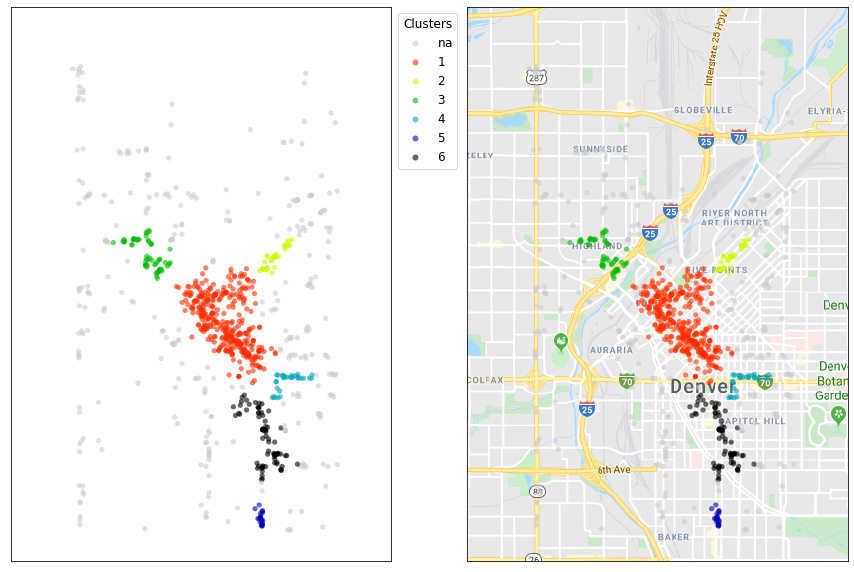

In [92]:
# plotting the clusters found running DBSCAN with epsilon = 0.003 and minPts = 15

# setting up plots
plt.rcParams.update({'font.size': 12})
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,20))

# plotting the first figure
ax1.set_xlim(-105.04, -104.96)
ax1.set_ylim(39.71*lat_adj_factor,39.8*lat_adj_factor)
ax1.set_aspect('equal')
scatter = ax1.scatter(x=df['longitude'],y=df['latitude_adj'],marker='.', s=110, lw=0, alpha=.6,c=clusters,cmap='nipy_spectral_r')
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

# plotting the second figure
ax2.set_xlim(-105.04, -104.96)
ax2.set_ylim(39.71*lat_adj_factor,39.8*lat_adj_factor)
ax2.set_aspect('equal')
scatter = ax2.scatter(x=df['longitude'],y=df['latitude_adj'],marker='.', s=110, lw=0, alpha=.6,c=clusters,cmap='nipy_spectral_r')
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])

# plotting the map of Denver on the second figure
ax2.imshow(denver_img, extent=[-105.04, -104.96, 39.7*lat_adj_factor, 39.8*lat_adj_factor],alpha = 1)

# plotting the legend between the two figures
hdls, lbls = scatter.legend_elements(prop="colors", alpha=0.6)
lbls_new = []
for lbl in lbls:
    char_list = [char for char in lbl]
    char_index = lbl.find("{") + 1
    if char_list[char_index].isnumeric():
        char_list[char_index] = str(int(char_list[char_index]) + 1)
    else:
        char_list[char_index] = 'na'
        char_list[char_index + 1] = ''
    lbl = ''.join([char for char in char_list])
    lbls_new.append(lbl)
legend = ax1.legend(handles = hdls, labels = lbls_new,loc="upper right", bbox_to_anchor=(1.19, 1), title="Clusters")


In [93]:
# calculating cluster centers and cluster radii for DBSCAN with eps = 0.003 and minPts = 15

individual_restaurants = df[['longitude','latitude_adj']].copy()
individual_restaurants['cluster'] = clusters
cluster_centers = pd.DataFrame(columns=['longitude','latitude_adj'])
cluster_radii = []

for cluster in np.unique(clusters):
    if cluster == -1:
        pass
    else:
        # create a data frame for the cluster
        df_temp = individual_restaurants[individual_restaurants['cluster'] == cluster].copy()
        df_temp.drop(columns = ['cluster'], inplace=True)
        # for each point in the cluster, determine the furthest point away also in that cluster
        furthest = []
        for i in cdist(df_temp, df_temp, 'euclidean'):
            furthest_point = i.max() * meters_conv
            furthest.append(furthest_point)
        # identify the 'center' as the point with the minimum distance to the 'furthest away' point
        index, distance = min(enumerate(furthest), key=operator.itemgetter(1))
        cluster_radii.append(distance)
        cluster_centers = cluster_centers.append(pd.DataFrame(df_temp.iloc[index]).transpose())

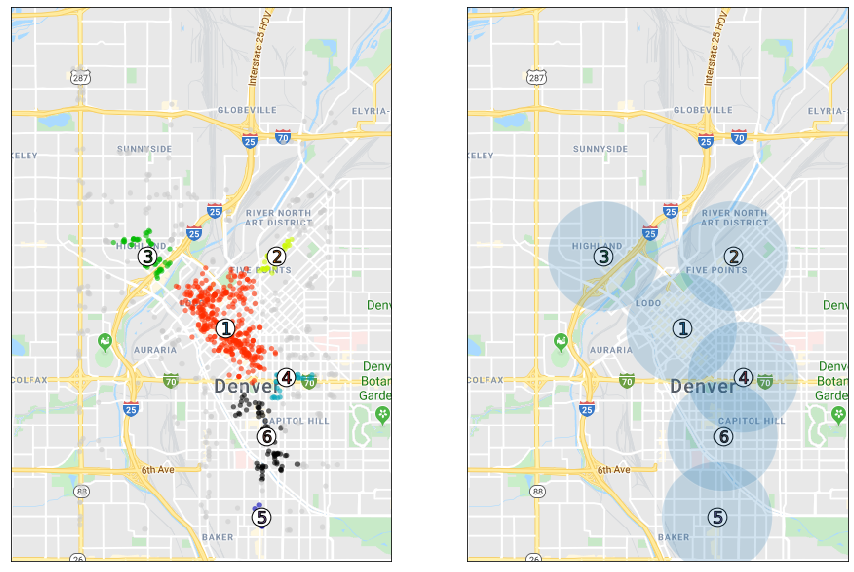

In [95]:
# plotting the cluster centers found running DBSCAN with epsilon = 0.003 and minPts = 15

# setting up plots
plt.rcParams.update({'font.size': 12})
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,20))

# setting up first figure
ax1.set_xlim(-105.04, -104.96)
ax1.set_ylim(39.71*lat_adj_factor,39.8*lat_adj_factor)
ax1.set_aspect('equal')
ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

# setting up second figure
ax2.set_xlim(-105.04, -104.96)
ax2.set_ylim(39.71*lat_adj_factor,39.8*lat_adj_factor)
ax2.set_aspect('equal')
ax2.get_xaxis().set_ticks([])
ax2.get_yaxis().set_ticks([])

# plotting the map of Denver on both figures
ax1.imshow(denver_img, extent=[-105.04, -104.96, 39.7*lat_adj_factor, 39.8*lat_adj_factor],alpha = 1)
ax2.imshow(denver_img, extent=[-105.04, -104.96, 39.7*lat_adj_factor, 39.8*lat_adj_factor],alpha = 1)

# plotting the scatter plot on figure 1
scatter = ax1.scatter(x=df['longitude'],y=df['latitude_adj'],marker='.', s=110, lw=0, alpha=.6,c=clusters,cmap='nipy_spectral_r')
        
# plotting the cluster radius on figure 2
for i in cluster_centers.index:
    x,y = cluster_centers.loc[i]['longitude'], cluster_centers.loc[i]['latitude_adj']
    circle = plt.Circle((x,y), radius=1000/meters_conv, alpha=.2,edgecolor='white')
    ax2.add_patch(circle)

# plotting the cluster centers on both figures
ax1.scatter(cluster_centers['longitude'], cluster_centers['latitude_adj'], marker='o', c="white", alpha=1, s=350, edgecolor='k')        
for i, c in enumerate(cluster_centers.to_numpy()):
        i += 1
        ax1.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=150, edgecolor='k')
ax2.scatter(cluster_centers['longitude'], cluster_centers['latitude_adj'], marker='o', c="white", alpha=1, s=350, edgecolor='k')        
for i, c in enumerate(cluster_centers.to_numpy()):
        i += 1
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=150, edgecolor='k')

In [96]:
# adding cluster assignments to dataframe
dist_data = cdist(df[['longitude','latitude_adj']], cluster_centers, 'euclidean')
columns = ['dist_clstr1','dist_clstr2','dist_clstr3','dist_clstr4','dist_clstr5','dist_clstr6'] ## Need to check which cluster is which... 
df_temp = pd.DataFrame(data = dist_data, columns=columns) * meters_conv
df_temp['clstr1'] = df_temp['dist_clstr1'].apply(lambda x: 1 if x <= 1000 else 0)
df_temp['clstr2'] = df_temp['dist_clstr2'].apply(lambda x: 1 if x <= 1000 else 0)
df_temp['clstr3'] = df_temp['dist_clstr3'].apply(lambda x: 1 if x <= 1000 else 0)
df_temp['clstr4'] = df_temp['dist_clstr4'].apply(lambda x: 1 if x <= 1000 else 0)
df_temp['clstr5'] = df_temp['dist_clstr5'].apply(lambda x: 1 if x <= 1000 else 0)
df_temp['clstr6'] = df_temp['dist_clstr6'].apply(lambda x: 1 if x <= 1000 else 0)
df_col = df.columns.tolist()
df = pd.concat([df, df_temp], axis=1, sort=False, ignore_index=True)
df_col.extend(df_temp.columns.tolist())
df.columns = df_col

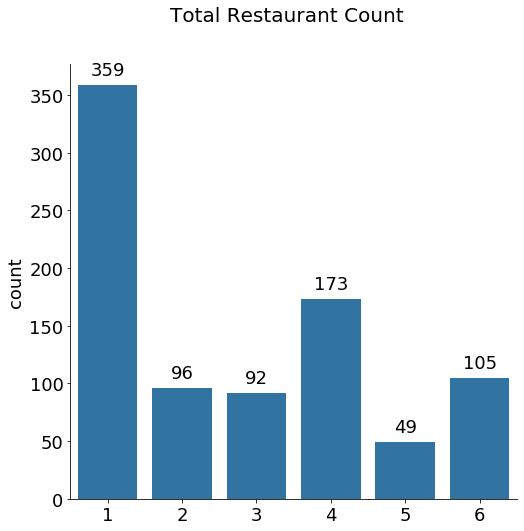

In [323]:
# plotting counts
plt.rcParams.update({'font.size': 18})

fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(8,8),sharey=True)
plt.subplots_adjust(wspace = 0)
ax_dict = {1:ax1,2:ax2,3:ax3,4:ax4,5:ax5,6:ax6}
fig.suptitle('Total Restaurant Count', fontsize=20)

for i in range(1,7):
    df_temp = df[df['clstr'+str(i)] == 1]
    sns.countplot(x=(np.ones(len(df_temp))*i), ax=ax_dict[i])
    ax_dict[i].spines['top'].set_visible(False)
    ax_dict[i].spines['right'].set_visible(False)
    ax_dict[i].set_xticklabels([i])
    if i > 1:
        ax_dict[i].axes.get_yaxis().set_visible(False)
        ax_dict[i].spines['left'].set_visible(False)
    rects = ax_dict[i].patches
    labels = [len(df_temp)]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax_dict[i].text(rect.get_x() + rect.get_width() / 2, height +5, label, ha='center', va='bottom')

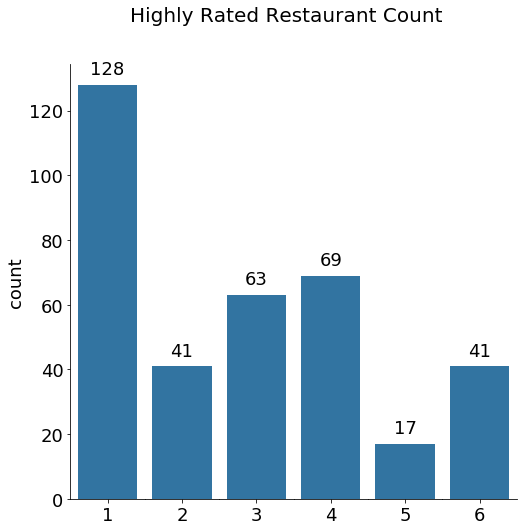

In [324]:
# plotting highly rated & reviewed counts
plt.rcParams.update({'font.size': 18})

fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(8,8),sharey=True)
plt.subplots_adjust(wspace = 0)
ax_dict = {1:ax1,2:ax2,3:ax3,4:ax4,5:ax5,6:ax6}
fig.suptitle('Highly Rated Restaurant Count', fontsize=20)

for i in range(1,7):
    df_temp = df[(df['clstr'+str(i)] == 1) & (df['review_count'] > 50) & (df['rating'] >= 4) ]
    sns.countplot(x=(np.ones(len(df_temp))*i), ax=ax_dict[i])
    ax_dict[i].spines['top'].set_visible(False)
    ax_dict[i].spines['right'].set_visible(False)
    ax_dict[i].set_xticklabels([i])
    if i > 1:
        ax_dict[i].axes.get_yaxis().set_visible(False)
        ax_dict[i].spines['left'].set_visible(False)
    rects = ax_dict[i].patches
    labels = [len(df_temp)]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax_dict[i].text(rect.get_x() + rect.get_width() / 2, height + 2, label, ha='center', va='bottom')

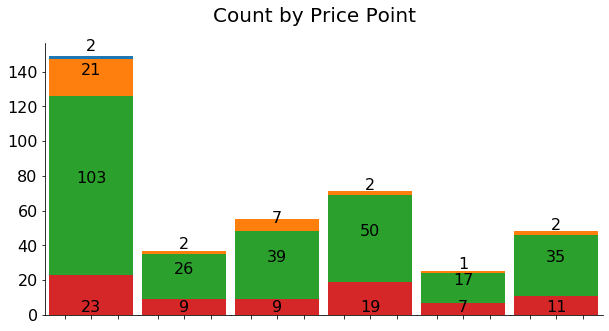

In [317]:
# Plotting Price Points
plt.rcParams.update({'font.size': 16})

fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(10,5),sharey=True)
plt.subplots_adjust(wspace = 0)
ax_dict = {1:ax1,2:ax2,3:ax3,4:ax4,5:ax5,6:ax6}
fig.suptitle('Count by Price Point', fontsize=20)

for i in range(1,7):
    count1 = len(df[(df['clstr'+str(i)] == 1) & (df['review_count'] > 150) & (df['price'] == '$')])
    count2 = len(df[(df['clstr'+str(i)] == 1) & (df['review_count'] > 150) & (df['price'] == '$$')])
    count3 = len(df[(df['clstr'+str(i)] == 1) & (df['review_count'] > 150) & (df['price'] == '$$$')])
    count4 = len(df[(df['clstr'+str(i)] == 1) & (df['review_count'] > 150) & (df['price'] == '$$$$')])
    ax_dict[i].bar(x=i,height=count1+count2+count3+count4,label='$$$$')
    ax_dict[i].bar(x=i,height=count1+count2+count3,label='$$$')
    ax_dict[i].bar(x=i,height=count1+count2,label='$$')
    ax_dict[i].bar(x=i,height=count1,label='$')    
    ax_dict[i].spines['top'].set_visible(False)
    ax_dict[i].spines['right'].set_visible(False)
    ax_dict[i].set_xticklabels([i])
    if i > 1:
        ax_dict[i].axes.get_yaxis().set_visible(False)
        ax_dict[i].spines['left'].set_visible(False)
    rects = ax_dict[i].patches
    ax_dict[i].text(rects[1].get_x() + rects[1].get_width() / 2, (rects[2].get_height() + rects[1].get_height()) / 2, count3, ha='center', va='bottom')
    ax_dict[i].text(rects[2].get_x() + rects[2].get_width() / 2, (rects[3].get_height() + rects[2].get_height()) / 2, count2, ha='center', va='bottom')
    ax_dict[i].text(rects[3].get_x() + rects[3].get_width() / 2, 0 , count1, ha='center', va='bottom')
    if i == 1:
            ax_dict[i].text(rects[0].get_x() + rects[0].get_width() / 2, rects[0].get_height() + 1, count4, ha='center', va='bottom')


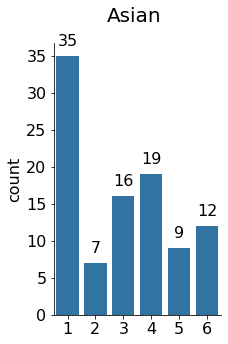

In [326]:
# plotting asian counts
plt.rcParams.update({'font.size': 16})

fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(3,5),sharey=True)
plt.subplots_adjust(wspace = 0)
ax_dict = {1:ax1,2:ax2,3:ax3,4:ax4,5:ax5,6:ax6}
fig.suptitle('Asian', fontsize=20)
#ax1.set_ylim(0,215)

for i in range(1,7):
    df_temp = df[(df['clstr'+str(i)] == 1) & (df['asian'] == 1) ]
    sns.countplot(x=(np.ones(len(df_temp))*i), ax=ax_dict[i])
    ax_dict[i].spines['top'].set_visible(False)
    ax_dict[i].spines['right'].set_visible(False)
    ax_dict[i].set_xticklabels([i])
    if i > 1:
        ax_dict[i].axes.get_yaxis().set_visible(False)
        ax_dict[i].spines['left'].set_visible(False)
    rects = ax_dict[i].patches
    labels = [len(df_temp)]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax_dict[i].text(rect.get_x() + rect.get_width() / 2, height + 1, label, ha='center', va='bottom')

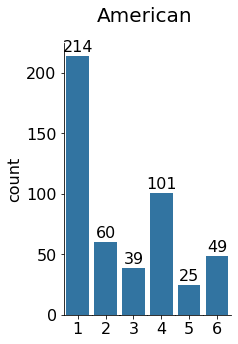

In [328]:
# plotting american counts
plt.rcParams.update({'font.size': 16})

fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(3,5),sharey=True)
plt.subplots_adjust(wspace = 0)
ax_dict = {1:ax1,2:ax2,3:ax3,4:ax4,5:ax5,6:ax6}
fig.suptitle('American', fontsize=20)
# ax1.set_ylim(0,215)

for i in range(1,7):
    df_temp = df[(df['clstr'+str(i)] == 1) & (df['american'] == 1) ]
    sns.countplot(x=(np.ones(len(df_temp))*i), ax=ax_dict[i])
    ax_dict[i].spines['top'].set_visible(False)
    ax_dict[i].spines['right'].set_visible(False)
    ax_dict[i].set_xticklabels([i])
    if i > 1:
        ax_dict[i].axes.get_yaxis().set_visible(False)
        ax_dict[i].spines['left'].set_visible(False)
    rects = ax_dict[i].patches
    labels = [len(df_temp)]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax_dict[i].text(rect.get_x() + rect.get_width() / 2, height + 1, label, ha='center', va='bottom')

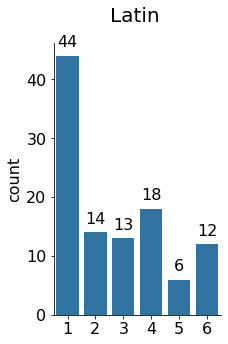

In [329]:
# plotting latin counts
plt.rcParams.update({'font.size': 16})

fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(3,5),sharey=True)
plt.subplots_adjust(wspace = 0)
ax_dict = {1:ax1,2:ax2,3:ax3,4:ax4,5:ax5,6:ax6}
fig.suptitle('Latin', fontsize=20)
# ax1.set_ylim(0,215)

for i in range(1,7):
    df_temp = df[(df['clstr'+str(i)] == 1) & (df['latin'] == 1) ]
    sns.countplot(x=(np.ones(len(df_temp))*i), ax=ax_dict[i])
    ax_dict[i].spines['top'].set_visible(False)
    ax_dict[i].spines['right'].set_visible(False)
    ax_dict[i].set_xticklabels([i])
    if i > 1:
        ax_dict[i].axes.get_yaxis().set_visible(False)
        ax_dict[i].spines['left'].set_visible(False)
    rects = ax_dict[i].patches
    labels = [len(df_temp)]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax_dict[i].text(rect.get_x() + rect.get_width() / 2, height + 1, label, ha='center', va='bottom')

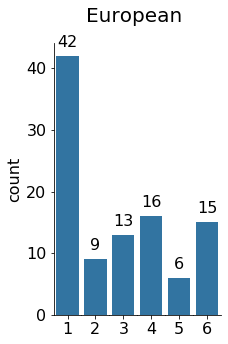

In [330]:
# plotting european counts
plt.rcParams.update({'font.size': 16})

fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(3,5),sharey=True)
plt.subplots_adjust(wspace = 0)
ax_dict = {1:ax1,2:ax2,3:ax3,4:ax4,5:ax5,6:ax6}
fig.suptitle('European', fontsize=20)
# ax1.set_ylim(0,215)

for i in range(1,7):
    df_temp = df[(df['clstr'+str(i)] == 1) & (df['european'] == 1) ]
    sns.countplot(x=(np.ones(len(df_temp))*i), ax=ax_dict[i])
    ax_dict[i].spines['top'].set_visible(False)
    ax_dict[i].spines['right'].set_visible(False)
    ax_dict[i].set_xticklabels([i])
    if i > 1:
        ax_dict[i].axes.get_yaxis().set_visible(False)
        ax_dict[i].spines['left'].set_visible(False)
    rects = ax_dict[i].patches
    labels = [len(df_temp)]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax_dict[i].text(rect.get_x() + rect.get_width() / 2, height + 1, label, ha='center', va='bottom')

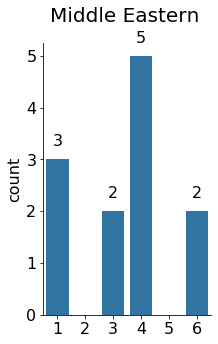

In [334]:
# plotting Middle Eastern counts
plt.rcParams.update({'font.size': 16})

fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(3,5),sharey=True)
plt.subplots_adjust(wspace = 0)
ax_dict = {1:ax1,2:ax2,3:ax3,4:ax4,5:ax5,6:ax6}
fig.suptitle('Middle Eastern', fontsize=20)
# ax1.set_ylim(0,215)

for i in range(1,7):
    df_temp = df[(df['clstr'+str(i)] == 1) & (df['middle_eastern'] == 1) ]
    if len(df_temp) == 0:
        ax_dict[i].set_xlim(i-0.5,i+0.5)
        ax_dict[i].set_xticks([i])
    else:
        sns.countplot(x=(np.ones(len(df_temp))*i), ax=ax_dict[i])
    ax_dict[i].spines['top'].set_visible(False)
    ax_dict[i].spines['right'].set_visible(False)
    ax_dict[i].set_xticklabels([i])
    if i > 1:
        ax_dict[i].axes.get_yaxis().set_visible(False)
        ax_dict[i].spines['left'].set_visible(False)
    rects = ax_dict[i].patches
    labels = [len(df_temp)]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax_dict[i].text(rect.get_x() + rect.get_width() / 2, height + .2, label, ha='center', va='bottom')

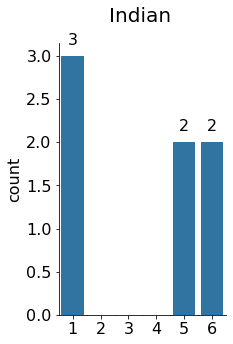

In [336]:
# plotting Indian counts
plt.rcParams.update({'font.size': 16})

fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6,figsize=(3,5),sharey=True)
plt.subplots_adjust(wspace = 0)
ax_dict = {1:ax1,2:ax2,3:ax3,4:ax4,5:ax5,6:ax6}
fig.suptitle('Indian', fontsize=20)
# ax1.set_ylim(0,215)

for i in range(1,7):
    df_temp = df[(df['clstr'+str(i)] == 1) & (df['indian'] == 1) ]
    if len(df_temp) == 0:
        ax_dict[i].set_xlim(i-0.5,i+0.5)
        ax_dict[i].set_xticks([i])
    else:
        sns.countplot(x=(np.ones(len(df_temp))*i), ax=ax_dict[i])
    ax_dict[i].spines['top'].set_visible(False)
    ax_dict[i].spines['right'].set_visible(False)
    ax_dict[i].set_xticklabels([i])
    if i > 1:
        ax_dict[i].axes.get_yaxis().set_visible(False)
        ax_dict[i].spines['left'].set_visible(False)
    rects = ax_dict[i].patches
    labels = [len(df_temp)]
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax_dict[i].text(rect.get_x() + rect.get_width() / 2, height + .1, label, ha='center', va='bottom')